# Loan Dataset Exploratory Data Analysis

**Objective**:  Explore the loan dataset to understand its structure, data quality, and key patterns relevant for building a loan risk prediction model (Lightgbm). We will identify a suitable target variable (loan default outcome) and analyze how other features relate to this target. The focus is on actionable insights (not just generic EDA steps) that will inform modeling of loan risk.

---

## 1. Data Overview and Structure

First, we load the dataset and examine its dimensions and sample contents:

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('D:/MLE/data/raw/original/loan.csv')
print("Dataset Shape: ",df.shape) 
df.head(5) 


Dataset Shape:  (577682, 19)


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


The dataset contains 577682 records (loan applications) and 19 columns. Each row represents a loan application (and if the loan is approved) with various attributes. Below are the first few rows of key columns for a quick review:

From this preview:

- **loanId** is a unique identifier for each loan application.  
- **anon_ssn** is client's unique identifier
- **payFrequency** is a code for repayment frequency (e.g. B = biweekly payments, I = irregular, M = monthly, S = semi monthly, W = weekly).  
- **apr** is the annual percentage rate of the loan.  
- **originated** and **approved** are boolean flags indicating progress in the underwriting process (whether the loan was originated, and finally approved).  
- **isFunded** indicates if the loan was actually funded (disbursed).  
- **loanStatus** is the current status/outcome of the loan (e.g. Withdrawn Application, Paid Off Loan, Rejected, etc.).  
- **loanAmount** is the principal loan amount.  
- **state** is the applicant’s state (location).  
- **leadType** indicates the source/type of customer lead (e.g. bvMandatory for bought leads requiring bank verification, organic for website signups, etc.).  
- **Lead cost** is the cost of the lead.
- **nPaidOff** is the number of previous loans this customer has paid off with the company (repeat customer history).


---

## Data Quality and Missing Values

Let's check for missing values in the dataset:

In [3]:
df.isnull().sum().sort_values(ascending=False).head(10)


originatedDate    531638
fpStatus          525959
clarityFraudId    219989
apr                 3922
loanAmount          2250
payFrequency        1273
loanStatus           391
loanId               256
state                132
nPaidOff              24
dtype: int64

Output (top columns by missing count):

- **originatedDate** – 531,638 missing (92%): Only populated if the loan was originated (most applications did not reach origination).  
- **fpStatus** – 525,959 missing (91% of entries): This field (first payment status) is not applicable for most records, since only funded loans have a first payment.  
- **clarityFraudId** – 219,989 missing (38%): Missing when no fraud record is associated (indicated by hasCF flag).  
- **loanId** – 256 missing (negligible portion).  
- **payFrequency** – 1,273 missing (~0.2%).  
- **apr** – 3,922 missing (~0.7%).  
- **loanStatus** – 391 missing (~0.07%).  
- **loanAmount** – 2,250 missing (~0.4%).  
- **state** – 132 missing.


Most missing values occur in fields that only apply to loans that progressed to later stages. For example, originatedDate and fpStatus are null for the vast majority of records because most applications never became an originated, funded loan. It means that the issues or missing values in the data are not necessarily errors, but rather are a result of the nature of the dataset or its structure. We will account for this by focusing analysis on relevant subsets (funded loans) when necessary.

Next, we need to determine the target variable for our loan risk model. The likely target is whether a loan defaults or not. We will derive this from the **loanStatus**.

---

## Defining the Target: Loan Status Analysis

Let's inspect the distribution of loanStatus, which describes each loan’s final or current state:

In [6]:
total = len(df)
df['loanStatus'].value_counts(dropna=False).head(10).to_frame(name='count').assign(
    percentage=lambda x: (x['count'] / total) * 100
)


,count,percentage
loanStatus,,
Withdrawn Application,450984,78.067864
Rejected,85070,14.726095
Paid Off Loan,11427,1.978078
External Collection,11334,1.961979
New Loan,8112,1.404233
Internal Collection,5567,0.963679
Returned Item,1182,0.204611
CSR Voided New Loan,1026,0.177606
Settlement Paid Off,708,0.122559


Output (top statuses):

- **Withdrawn Application** – 450,984 (78% of all records)  
- **Rejected** – 85,070 (14.7%)  
- **Paid Off Loan** – 11,427 (2.0%)  
- **External Collection** – 11,334 (2.0%)  
- **New Loan (active, ongoing)** – 8,112 (1.4%)  
- **Internal Collection** – 5,567 (1.0%)  
- **Returned Item** – 1,182 (0.2%)  
- **Other statuses** (each <0.2%) like CSR Voided New Loan (1,026), Settlement Paid Off (708), Credit Return Void (704), etc.


Most applications never became active loans: nearly 78% were “Withdrawn Application” (the applicant abandoned or withdrew the application) and 15% “Rejected” by automated rules, meaning they were declined during underwriting. These represent applications that did not result in a funded loan. Only a small fraction of entries correspond to actual loans that were funded and reached an outcome. Funded loan outcomes: To focus on loan performance (risk outcomes), we isolate the ~38.9k funded loans (isFunded=1). The loanStatus distribution for funded loans is much different:

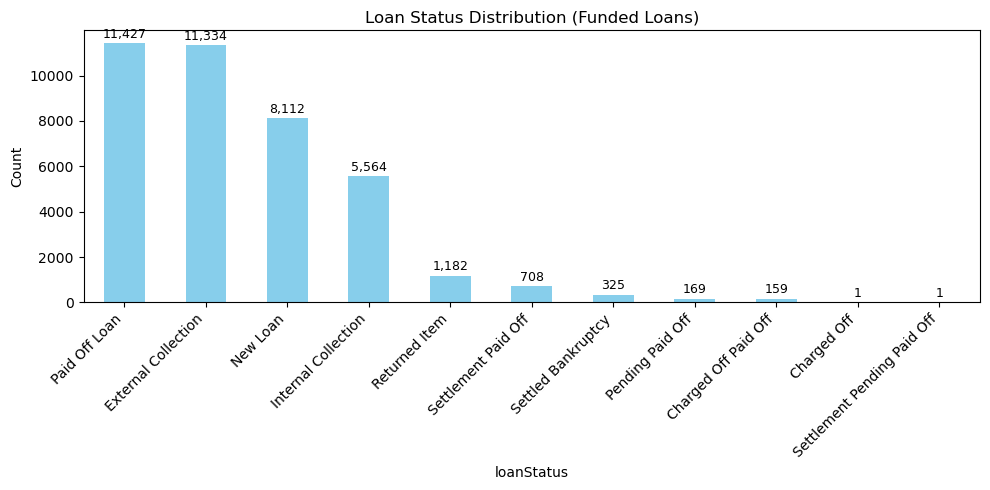

In [15]:
funded_df = df[df['isFunded'] == 1]

status_counts = funded_df['loanStatus'].value_counts()
plt.figure(figsize=(10, 5))
bars = status_counts.plot(kind='bar', color='skyblue')
plt.title('Loan Status Distribution (Funded Loans)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for i, count in enumerate(status_counts):
    plt.text(i, count + max(status_counts) * 0.01, f'{count:,}', ha='center', va='bottom', fontsize=9)

plt.show()



Distribution of loan status for funded loans.
(Most loans either fully paid off, currently active, or ended in default-related statuses.)

Among funded loans:

- **Paid Off Loan**: 11,427 loans (the loan was fully paid back – a “good” outcome).  
- **External Collection**: 11,334 loans went to external collections (a severe default outcome).  
- **New Loan**: 8,112 are current active loans (still in repayment, not yet completed).  
- **Internal Collection**: 5,564 loans in internal collection efforts (seriously delinquent – default).  
- **Returned Item**: 1,182 loans have a “Returned Item” status, meaning at least one payment was missed due to insufficient funds (an early delinquency, though not yet a full default).  
- **Settlement Paid Off**: 708 loans were settled (paid off via settlement, typically after defaulting on original terms).  
- **Settled Bankruptcy**: 325 loans ended in bankruptcy settlement.  
- **Pending Paid Off**: 169 loans in the process of payoff (almost completed).  
- **Charged Off Paid Off**: 159 loans were charged off but later paid (recovered after default).  
- *(Plus a handful of other edge cases: e.g., 1 loan “Charged Off”, 1 “Settlement Pending Paid Off”.)*


### Key Observation

For modeling loan default risk, we should define a binary target indicating whether a loan eventually defaulted.

- We can consider **“default”** as any outcome where the borrower failed to repay in full under the original terms.  
  This includes statuses like:
  - **External or Internal Collection**
  - **Charged Off** (even if later paid)
  - **Settled** (often implies not full repayment)
  - **Bankruptcy**  
  Essentially, all outcomes **except** "Paid Off" (and possibly those still active or pending payoff) can be treated as defaults or bad outcomes.

- **“Non-default”** (good outcome) would be loans that were **fully paid off as agreed**, including those **pending final payment**, which are on track to be paid off.

We have to decide how to handle active loans (**New Loan** and **Returned Item** statuses): these loans have not reached a final outcome as of the data snapshot (they could eventually pay off or default). For the purpose of modeling, one approach is to exclude them from training (since their outcome is not known yet), or label them as non-default for now and treat them as censored. In this analysis, we will exclude active loans when computing final default rates to avoid bias, but we will note their presence.



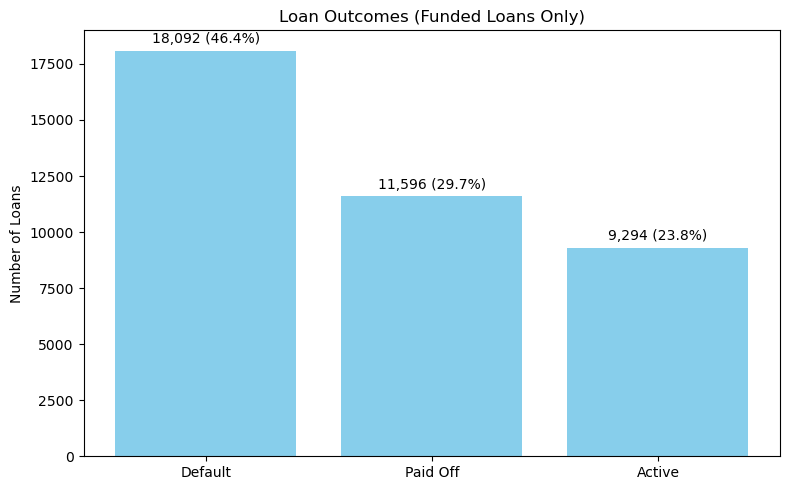

In [49]:
import matplotlib.pyplot as plt

funded_df = df[df['isFunded'] == 1].copy()

default_statuses = [
    'External Collection', 'Internal Collection', 
    'Charged Off', 'Charged Off Paid Off',
    'Settlement Paid Off', 'Settled Bankruptcy',
    'Settlement Pending Paid Off'
]
non_default_statuses = ['Paid Off Loan', 'Pending Paid Off']
active_statuses = ['New Loan', 'Returned Item']

def classify_outcome(status):
    if status in default_statuses:
        return 'Default'
    elif status in non_default_statuses:
        return 'Paid Off'
    elif status in active_statuses:
        return 'Active'
    else:
        return 'Other'

funded_df['loanOutcome'] = funded_df['loanStatus'].apply(classify_outcome)

outcome_counts = funded_df['loanOutcome'].value_counts()
outcome_percent = (outcome_counts / outcome_counts.sum()) * 100

plt.figure(figsize=(8, 5))
bars = plt.bar(outcome_counts.index, outcome_counts.values, color='skyblue')
plt.title('Loan Outcomes (Funded Loans Only)')
plt.ylabel('Number of Loans')

for bar, count, pct in zip(bars, outcome_counts, outcome_percent):
    label = f'{int(count):,} ({pct:.1f}%)'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200, label,
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


Using the definitions above, approximately:

- **Defaulted loans**: ~18,092 (46% of funded, when considering final outcomes only) – This includes external/internal collections, charge-offs, settlements, etc.  
- **Paid-off loans**: ~11,596 (29.7% of funded).  
- **Active (ongoing) loans**: ~9,294 (23.8% of funded).

Thus, among loans that have reached an outcome (paid off or defaulted), the default rate is quite high (~60% default vs 40% paid). This indicates a challenging risk profile, likely due to the subprime nature of these loans. 

For modeling, we will treat **loanStatus** (funded loans) as the basis for our target: we can create a binary flag **isDefault** where:

In [50]:
# Filter to funded loans only
funded_df = df[df['isFunded'] == 1].copy()

default_statuses = [
    'External Collection', 'Internal Collection',
    'Charged Off', 'Charged Off Paid Off',
    'Settlement Paid Off', 'Settled Bankruptcy',
    'Settlement Pending Paid Off'
]

non_default_statuses = ['Paid Off Loan']

# Create binary isDefault flag
funded_df['isDefault'] = funded_df['loanStatus'].apply(
    lambda x: 1 if x in default_statuses else (0 if x in non_default_statuses else None)
)


1 = default_statuses, 0 = non_default_statuses

**Conclusion**: **loanStatus** is indeed the key field for loan performance. We will use it (consolidated to default vs paid) as the target variable for risk modeling. Now, let's explore how the other variables relate to this target and to each other.

---

## 3. Exploratory Analysis of Features and Relationships

We now investigate the features in detail, especially looking for patterns that differentiate defaulted loans vs paid loans. We focus only on funded loans for these analyses, since for risk modeling we care about loans that were actually issued.

**a. Loan Amount and Repayment Amount**

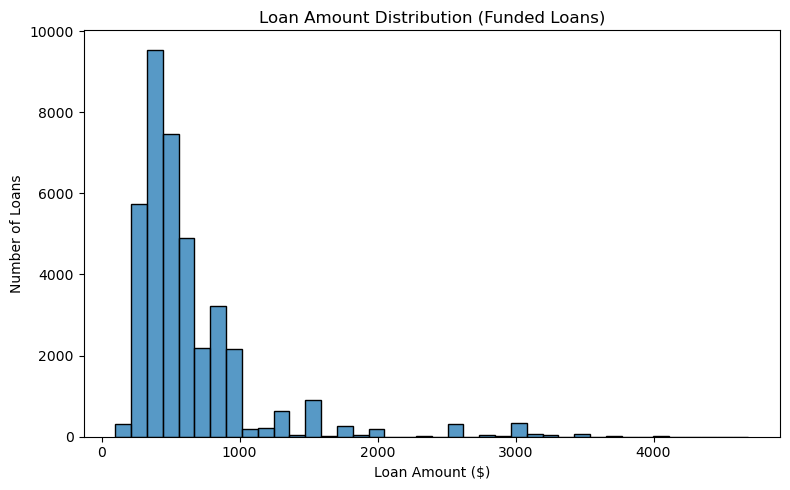

In [29]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(funded_df['loanAmount'], bins=40, kde=False)
plt.title('Loan Amount Distribution (Funded Loans)')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Number of Loans')
plt.tight_layout()
plt.show()


We can see that the vast majority of loans are under $1000. There is a peak around $500 (the median), and relatively few loans above $1500. A long tail extends to about $4,687 (the maximum), but those larger loans are rare. This indicates the lender primarily issues small-dollar loans.

Interestingly, we do not observe a strong correlation between loan size and default in this dataset:

- The **average loan amount** for defaulted loans (**$611**) is only slightly lower than for loans that were paid off (**$633**).  
- The **median** for both groups is **$500** .  
- In other words, borrowers with larger loans did not significantly default more or less than those with smaller loans — loan amount by itself doesn’t separate good vs bad loans strongly.

This could be because loan amounts were tightly controlled (perhaps first-time borrowers all start around $500), who likely all start at lower amounts due to risk policy. So, **loan size may not vary enough by risk** within the same customer tenure.


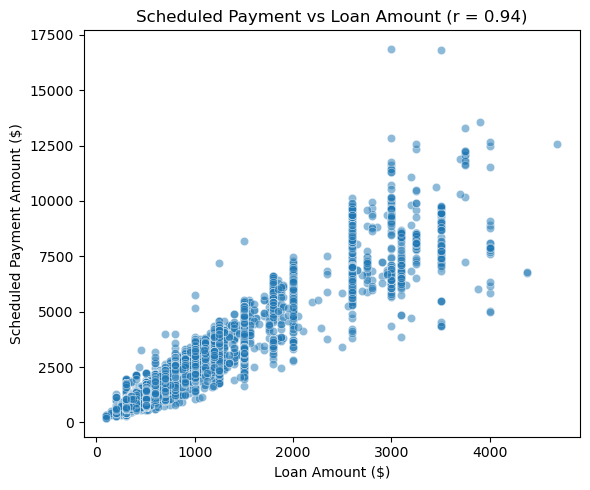

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with missing values in either column
corr_df = funded_df[['loanAmount', 'originallyScheduledPaymentAmount']].dropna()

# Calculate correlation
correlation = corr_df['loanAmount'].corr(corr_df['originallyScheduledPaymentAmount'])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=corr_df, x='loanAmount', y='originallyScheduledPaymentAmount', alpha=0.5)
plt.title(f'Scheduled Payment vs Loan Amount (r = {correlation:.2f})')
plt.xlabel('Loan Amount ($)')
plt.ylabel('Scheduled Payment Amount ($)')
plt.tight_layout()
plt.show()


**Scheduled Payment Amount**: There is a field `originallyScheduledPaymentAmount` which is highly correlated with `loanAmount`(correlation ≈ 0.94). This makes sense, as the scheduled payment would be determined largely by the loan amount (plus interest) and term. Because it provides similar information, we won’t analyze it separately in depth.

---

**b. Customer History (nPaidOff)**

A key variable is nPaidOff, the number of previous loans the borrower has paid off with the lender. This essentially measures customer tenure/loyalty and past performance:

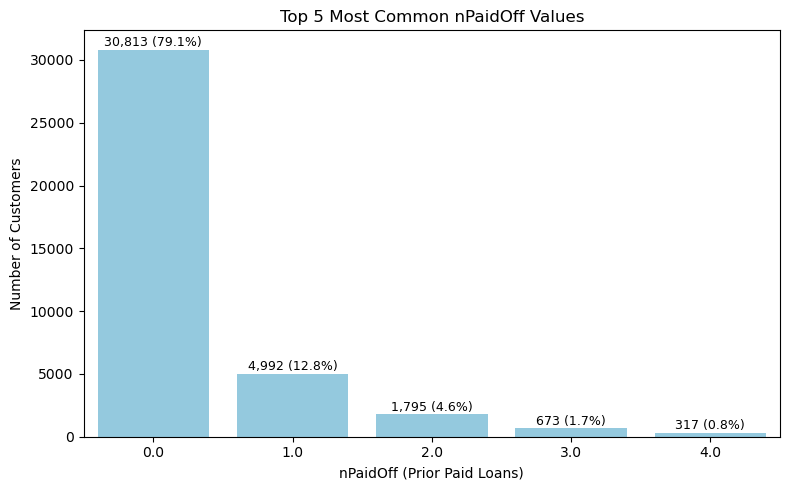

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NA for clean stats
npaid_df = funded_df.dropna(subset=['nPaidOff'])

# Total funded loans (for global %)
total_funded = len(npaid_df)
top5_values = npaid_df['nPaidOff'].value_counts().nlargest(5).index.tolist()
top5_df = npaid_df[npaid_df['nPaidOff'].isin(top5_values)]
ordered_x = sorted(top5_df['nPaidOff'].unique())


plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=top5_df,
    x='nPaidOff',
    color='skyblue',
    order=ordered_x
)

plt.title('Top 5 Most Common nPaidOff Values')
plt.xlabel('nPaidOff (Prior Paid Loans)')
plt.ylabel('Number of Customers')

# Add labels: count + % based on total
for bar in ax.patches:
    count = int(bar.get_height())
    pct = (count / total_funded) * 100
    label = f'{count:,} ({pct:.1f}%)'
    ax.text(bar.get_x() + bar.get_width()/2, count + 50, label,
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


- **79.1%** of funded loans were to **new customers** (`nPaidOff = 0`), i.e., first loan with the company.  
- The remaining ~**21.9%** were **repeat borrowers** who had paid off 1 or more prior loans.  
  - ~**12.8%** had **1 prior loan**  
  - ~**4.6%** had **2 prior loans**  
  - Very few had more — the maximum in the dataset is **21**, but these are **outliers**; most repeat borrowers had **3 or fewer** prior loans.


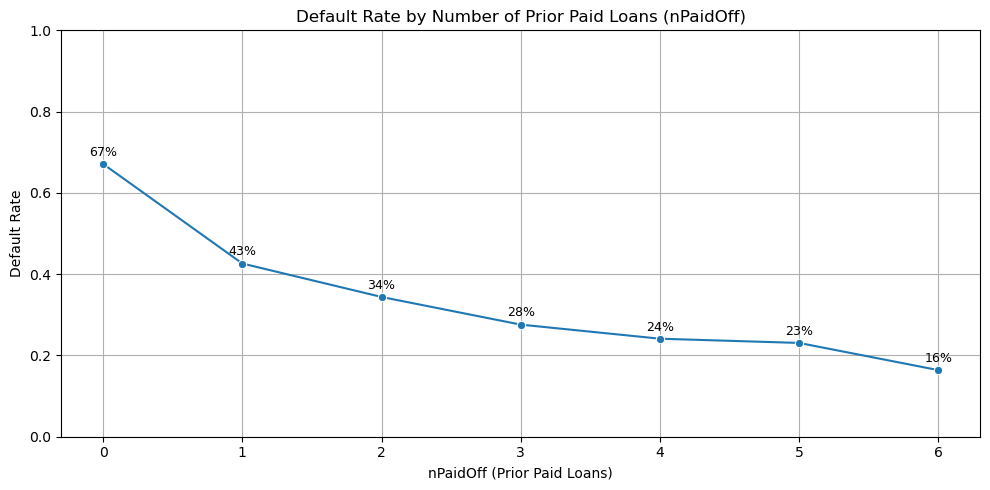

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


model_df = funded_df.dropna(subset=['nPaidOff', 'isDefault'])

# Group by nPaidOff and calculate default rate
default_by_npaid = model_df.groupby('nPaidOff')['isDefault'].agg(['mean', 'count']).reset_index()
default_by_npaid.rename(columns={'mean': 'default_rate'}, inplace=True)

# Keep only groups with enough data (filter for visibility)
default_by_npaid = default_by_npaid[default_by_npaid['count'] >= 50]

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=default_by_npaid, x='nPaidOff', y='default_rate', marker='o')
plt.title('Default Rate by Number of Prior Paid Loans (nPaidOff)')
plt.xlabel('nPaidOff (Prior Paid Loans)')
plt.ylabel('Default Rate')
plt.ylim(0, 1)
plt.grid(True)

# Add value labels
for _, row in default_by_npaid.iterrows():
    plt.text(row['nPaidOff'], row['default_rate'] + 0.02, f"{row['default_rate']:.0%}", 
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()


This variable has a strong relationship with default rates: borrowers with prior successful loans are **much less likely to default** on the current loan.

- **First-time borrowers** (`nPaidOff = 0`) – About **67%** defaulted on their loan (only ~33% paid off).  
- **1 prior loan paid** – Default rate drops to approximately **43%**.  
- **2 prior loans paid** – Default rate is around **34%**.  
- **3 prior loans paid** – Default rate falls further to about **28%**.  
- **4+ prior paid loans** – Default rates continue to decline, ranging between **15–25%**.

In other words, returning customers demonstrate better repayment behavior. This makes intuitive sense: customers who have proven they can pay off past loans likely have better creditworthiness (and possibly are rewarded with slightly larger loans or lower rates), whereas brand new customers are the riskiest segment. This insight suggests **nPaidOff** is an important predictor for the risk model.



---

**c. Interest Rate (APR)**

The dataset’s APRs are extremely high in general, but we check if higher rates correlate with higher default (which might indicate risk-based pricing capturing risk tiers).

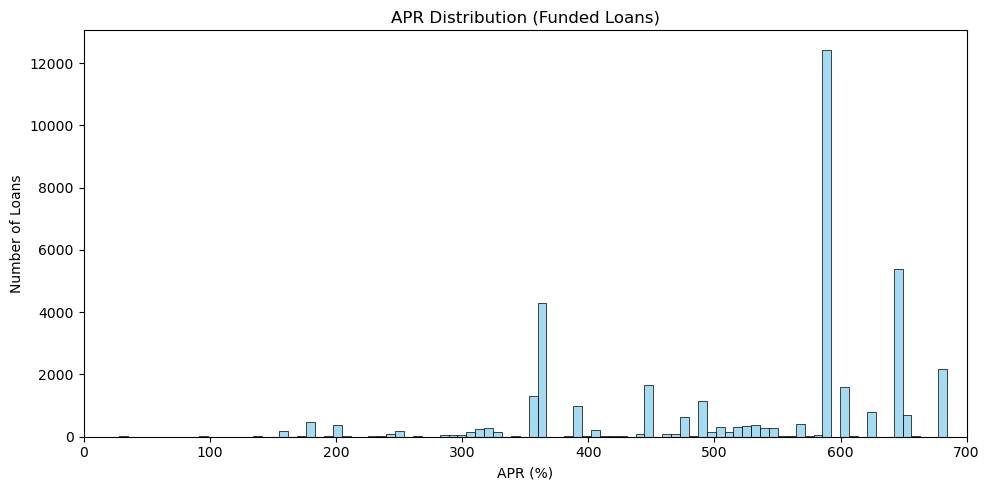

Median APR: 590%
Loans with ~0% APR: 3


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


apr_dist_df = funded_df.dropna(subset=['apr'])

# Plot APR distribution
plt.figure(figsize=(10, 5))
sns.histplot(apr_dist_df['apr'], bins=100, color='skyblue')
plt.title('APR Distribution (Funded Loans)')
plt.xlabel('APR (%)')
plt.ylabel('Number of Loans')
plt.xlim(0, 700) 
plt.tight_layout()
plt.show()

# Key APR stats
median_apr = apr_dist_df['apr'].median()
low_apr_count = (apr_dist_df['apr'] <= 0.01).sum() 

print(f"Median APR: {median_apr:.0f}%")
print(f"Loans with ~0% APR: {low_apr_count}")


APR distribution: There appear to be common APR values (e.g., a large number of loans at 590% APR, another group around 450% APR, and some lower clusters around 200-300%). These likely correspond to different product types or state regulations. Median APR is 590%. A small number of loans have very low APR (even 0% in 3 cases, possibly promotional or error).

Mean APR for defaulted loans: 540.8%
Mean APR for paid-off loans: 508.0%


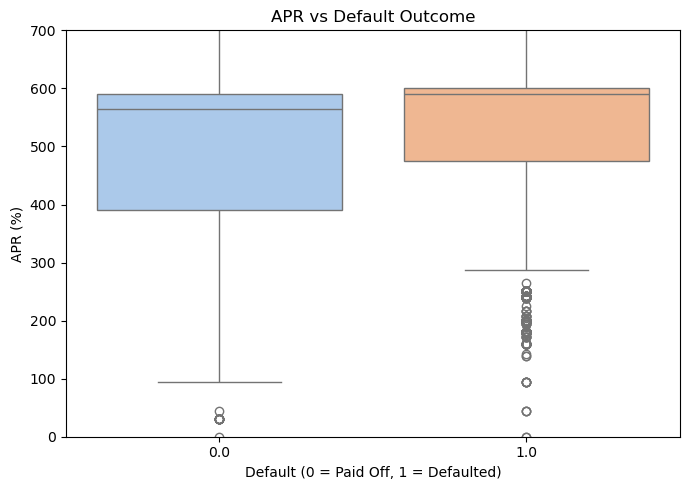

Correlation between APR and default: 0.14


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

apr_df = funded_df.dropna(subset=['apr', 'isDefault'])

# 1. Mean APR by default status
mean_apr_defaulted = apr_df[apr_df['isDefault'] == 1]['apr'].mean()
mean_apr_paid = apr_df[apr_df['isDefault'] == 0]['apr'].mean()

print(f"Mean APR for defaulted loans: {mean_apr_defaulted:.1f}%")
print(f"Mean APR for paid-off loans: {mean_apr_paid:.1f}%")

plt.figure(figsize=(7, 5))
sns.boxplot(data=apr_df, x='isDefault', y='apr', hue='isDefault', palette='pastel', legend=False)
plt.title('APR vs Default Outcome')
plt.xlabel('Default (0 = Paid Off, 1 = Defaulted)')
plt.ylabel('APR (%)')
plt.ylim(0, 700)
plt.tight_layout()
plt.show()


# 3. Correlation between APR and default
correlation = apr_df['apr'].corr(apr_df['isDefault'])
print(f"Correlation between APR and default: {correlation:.2f}")


APR vs default: We find that defaulted loans tend to have slightly higher APR on average. The mean APR for defaulted loans is ~540%, compared to ~508% for loans that were paid off. This suggests that higher-risk borrowers were indeed charged higher APRs, and they did default at a somewhat higher rate. However, the overlap is large – many paid-off loans also had high `APR`. A boxplot of APR by outcome shows considerable overlap. So `APR` alone is a mild risk indicator. (Correlation between `APR` and the `default flag` is +0.14 – a positive but modest correlation.)

Smaller loans tend to have higher APRs. This likely reflects how the lender’s pricing works (perhaps smaller, shorter-term loans have higher effective APR). Since we saw smaller loans also had slightly higher default incidence, it aligns that `APR` is capturing some of that risk relationship. But overall, APR is a less powerful separator than customer history or some categorical factors we’ll examine next.

---

**d. Categorical Variables: Lead Type, Pay Frequency, State**

Now let's explore how various categorical factors relate to default rates. Lead Type: This indicates how the borrower came to the lender (marketing/source channel), which often correlates with borrower quality. The major categories in our data and their default outcomes:

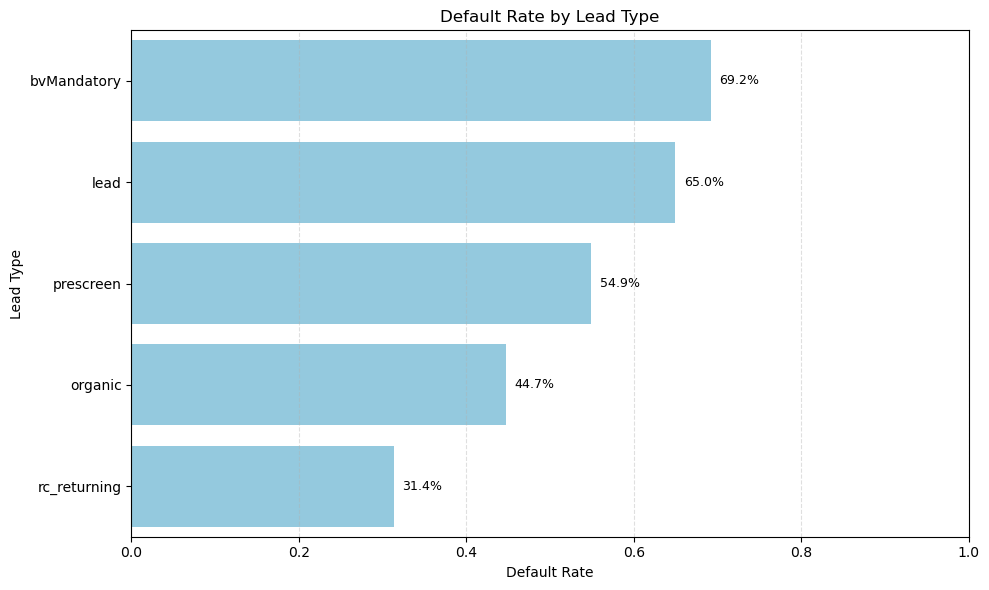

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

lead_df = funded_df.dropna(subset=['leadType', 'isDefault'])

lead_summary = (
    lead_df
    .groupby('leadType')['isDefault']
    .agg(['count', 'mean'])
    .rename(columns={'count': 'loan_count', 'mean': 'default_rate'})
    .reset_index()
)

# Filter only leadTypes with meaningful volume (>100 loans)
lead_summary = lead_summary[lead_summary['loan_count'] > 100]

# Sort by default rate
lead_summary = lead_summary.sort_values(by='default_rate', ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=lead_summary,
    y='leadType',
    x='default_rate',
    color='skyblue' 
)

plt.title('Default Rate by Lead Type')
plt.xlabel('Default Rate')
plt.ylabel('Lead Type')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Add percentage labels to the bars
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width + 0.01, y, f"{width * 100:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()



- **bvMandatory** – The largest group of loans (these are leads bought from brokers where bank verification is mandatory) – had a very high default rate of approximately **69%**. These are likely cold leads with higher risk.

- **lead** – Similar to `bvMandatory` but bank verification is optional – default rate around **65%**.

- **prescreen** – Leads from preselected offers (e.g., direct mail) – default rate around **54.9**.

- **organic** – Customers who came through the website organically – default rate approximately **44.7%**.

- **rc_returning** – Returning customers from another portfolio – default rate around **31.4%**, much lower than new leads.

**🔍** We clearly see lead source matters: customers acquired via paid lead sources (especially those requiring verification) default much more often than those who came organically or are returning customers. Returning customers are the safest group, reinforcing the earlier point about customer tenure. This suggests including `leadType` or features derived from it (e.g., whether the customer was a returning/prescreen vs a bought lead) could improve the risk model.



---

**Pay Frequency**

Borrowers can have different repayment frequencies (B = biweekly, W = weekly, S = semi-monthly, M = monthly, I = irregular). This might relate to their pay cycle or loan structure. Default rates by pay schedule show interesting differences:

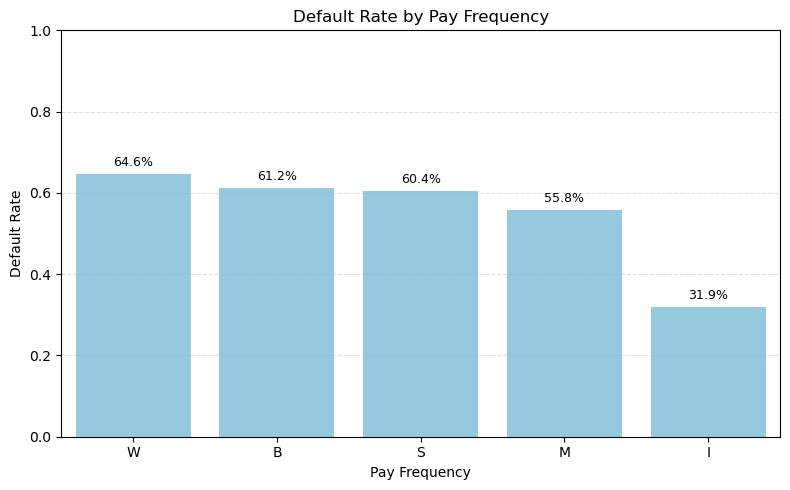

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pay_df = funded_df.dropna(subset=['payFrequency', 'isDefault'])

# Group and calculate default rate
pay_summary = (
    pay_df
    .groupby('payFrequency')['isDefault']
    .agg(['count', 'mean'])
    .rename(columns={'count': 'loan_count', 'mean': 'default_rate'})
    .reset_index()
    .sort_values(by='default_rate', ascending=False)
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=pay_summary,
    x='payFrequency',
    y='default_rate',
    color='skyblue'
)

plt.title('Default Rate by Pay Frequency')
plt.xlabel('Pay Frequency')
plt.ylabel('Default Rate')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add percentage labels
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    plt.text(x, height + 0.02, f"{height * 100:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


- **Weekly (W)**: ~64.6% default rate (**highest**). Weekly pay might be used for riskier borrowers (perhaps to collect small payments more frequently, yet many still default).

- **Biweekly (B)** and **Semi-monthly (S)**: Around **60–62%** default.

- **Monthly (M)**: ~**55.8%** default.

- **Irregular (I)**: ~**31.8%** default (**much lower**). Irregular may indicate a flexible plan or a different product type (small subset). The significantly lower default rate could mean these were selectively offered to better customers or had a different structure.

🔍 This suggests repayment frequency is a relevant factor. It might be partly endogenous (lenders might assign riskier customers to more frequent payments), but it could help the model. For instance, a weekly pay loan may signal higher inherent risk (and indeed outcomes show higher default).


---

**State**: The state of the borrower could capture regulatory differences or regional economic differences.

In [60]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests

# -------------------------------------
# Step 1: Aggregate loan metrics by state
# -------------------------------------
loan_summary = funded_df.groupby('state', as_index=False).agg(
    risk_ratio=('isDefault', 'mean'),
    total_loans=('loanAmount', 'count'),
    avg_loan_amount=('loanAmount', 'mean')
)

# -------------------------------------
# Step 2: Fetch Census Data
# -------------------------------------
CENSUS_API_KEY = "230efe0995ced4c72653b2a7d280678dab929534"
variables = ["NAME", "B19013_001E", "B23025_003E", "B23025_005E"]
url = (
    "https://api.census.gov/data/2016/acs/acs1"
    f"?get={','.join(variables)}"
    "&for=state:*"
    f"&key={CENSUS_API_KEY}"
)

response = requests.get(url)
if response.status_code != 200:
    raise Exception(f"Request failed: {response.status_code} - {response.text}")

data = response.json()
df_census = pd.DataFrame(data[1:], columns=data[0])

df_census.rename(columns={
    "NAME": "state_name",
    "B19013_001E": "median_income",
    "B23025_003E": "labor_force",
    "B23025_005E": "unemployed",
    "state": "state_fips"
}, inplace=True)

df_census["median_income"] = pd.to_numeric(df_census["median_income"], errors="coerce")
df_census["labor_force"] = pd.to_numeric(df_census["labor_force"], errors="coerce")
df_census["unemployed"] = pd.to_numeric(df_census["unemployed"], errors="coerce")
df_census["unemployment_rate"] = df_census["unemployed"] / df_census["labor_force"] * 100

# Map FIPS to state abbreviation
fips_to_abbrev = {
    '01': 'AL','02': 'AK','04': 'AZ','05': 'AR','06': 'CA','08': 'CO','09': 'CT','10': 'DE','11': 'DC',
    '12': 'FL','13': 'GA','15': 'HI','16': 'ID','17': 'IL','18': 'IN','19': 'IA','20': 'KS','21': 'KY',
    '22': 'LA','23': 'ME','24': 'MD','25': 'MA','26': 'MI','27': 'MN','28': 'MS','29': 'MO','30': 'MT',
    '31': 'NE','32': 'NV','33': 'NH','34': 'NJ','35': 'NM','36': 'NY','37': 'NC','38': 'ND','39': 'OH',
    '40': 'OK','41': 'OR','42': 'PA','44': 'RI','45': 'SC','46': 'SD','47': 'TN','48': 'TX','49': 'UT',
    '50': 'VT','51': 'VA','53': 'WA','54': 'WV','55': 'WI','56': 'WY'
}
df_census["state"] = df_census["state_fips"].map(fips_to_abbrev)

# -------------------------------------
# Step 3: Merge loan and census data
# -------------------------------------
state_summary = pd.merge(loan_summary, df_census, on='state', how='inner')

# -------------------------------------
# Step 4: Create 2-row, 3-column choropleth layout
# -------------------------------------
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[
        "Risk Ratio", "Total Loans", "Avg Loan Amount",
        "Median Income (2016)", "Unemployment Rate (2016)", ""
    ],
    specs=[
        [{"type": "choropleth"}, {"type": "choropleth"}, {"type": "choropleth"}],
        [{"type": "choropleth"}, {"type": "choropleth"}, None]
    ]
)

# -------------------------
# Row 1: Loan Metrics
# -------------------------
# Row 1: Loan Metrics (legends beside the maps)
fig.add_trace(go.Choropleth(
    locations=state_summary['state'],
    z=state_summary['risk_ratio'],
    locationmode="USA-states",
    colorscale="Reds",
    colorbar_title="Risk Ratio",
    geo="geo1",
    colorbar=dict(x=0.30, xanchor='left', y=0.83, len=0.3, thickness=10)
), row=1, col=1)

fig.add_trace(go.Choropleth(
    locations=state_summary['state'],
    z=state_summary['total_loans'],
    locationmode="USA-states",
    colorscale="Blues",
    colorbar_title="Total Loans",
    geo="geo2",
    colorbar=dict(x=0.63, xanchor='left', y=0.83, len=0.3, thickness=10)
), row=1, col=2)

fig.add_trace(go.Choropleth(
    locations=state_summary['state'],
    z=state_summary['avg_loan_amount'],
    locationmode="USA-states",
    colorscale="Greens",
    colorbar_title="Avg Loan ($)",
    geo="geo3",
    colorbar=dict(x=0.96, xanchor='left', y=0.83, len=0.3, thickness=10)
), row=1, col=3)


# -------------------------
# Row 2: Census Metrics
# -------------------------
fig.add_trace(go.Choropleth(
    locations=state_summary['state'],
    z=state_summary['median_income'],
    locationmode="USA-states",
    colorscale="Purples",
    colorbar_title="Median Income ($)",
    geo="geo4",
    colorbar=dict(x=0.3, y=0.25, len=0.3, thickness=10)
), row=2, col=1)

fig.add_trace(go.Choropleth(
    locations=state_summary['state'],
    z=state_summary['unemployment_rate'],
    locationmode="USA-states",
    colorscale="Oranges",
    colorbar_title="Unemp. Rate (%)",
    geo="geo5",
    colorbar=dict(x=0.7, y=0.25, len=0.3, thickness=10)
), row=2, col=2)

# -------------------------
# Layout Settings
# -------------------------
fig.update_layout(
    title="State-Level Loan & Economic Metrics",
    height=900,
    geo1=dict(scope='usa'),
    geo2=dict(scope='usa'),
    geo3=dict(scope='usa'),
    geo4=dict(scope='usa'),
    geo5=dict(scope='usa'),
    margin=dict(t=70, b=30, l=20, r=20)
)

fig.show()


## 📊 State-Level Loan & Economic Metrics

This dashboard provides a geographic overview of loan performance and economic indicators across U.S. states, based on internal loan data and U.S. Census metrics.

### 🔹 Loan Metrics (Top Row)
- **Risk Ratio (Default Rate):** Higher in many Southern and Western states, indicating more frequent defaults in those regions.
- **Total Loans:** Highest loan volumes in states like Texas, Illinois, and Ohio.
- **Average Loan Amount:** Georgia and California show significantly higher average loan sizes compared to other states.

### 🔹 Economic Metrics (Bottom Row)
- **Median Income (2016):** Highest in coastal and Northeastern states; lowest in parts of the South.
- **Unemployment Rate (2016):** Higher unemployment in Southern and Southwestern states; lower in the Midwest and Northern regions.

### 🔍 Key Takeaway
There are visible geographic patterns: states with lower median income and higher unemployment tend to align with higher loan default rates, though exceptions exist. These insights can inform region-specific risk modeling or product strategies.


___

***e. Correlation Matrix of Numeric Features***

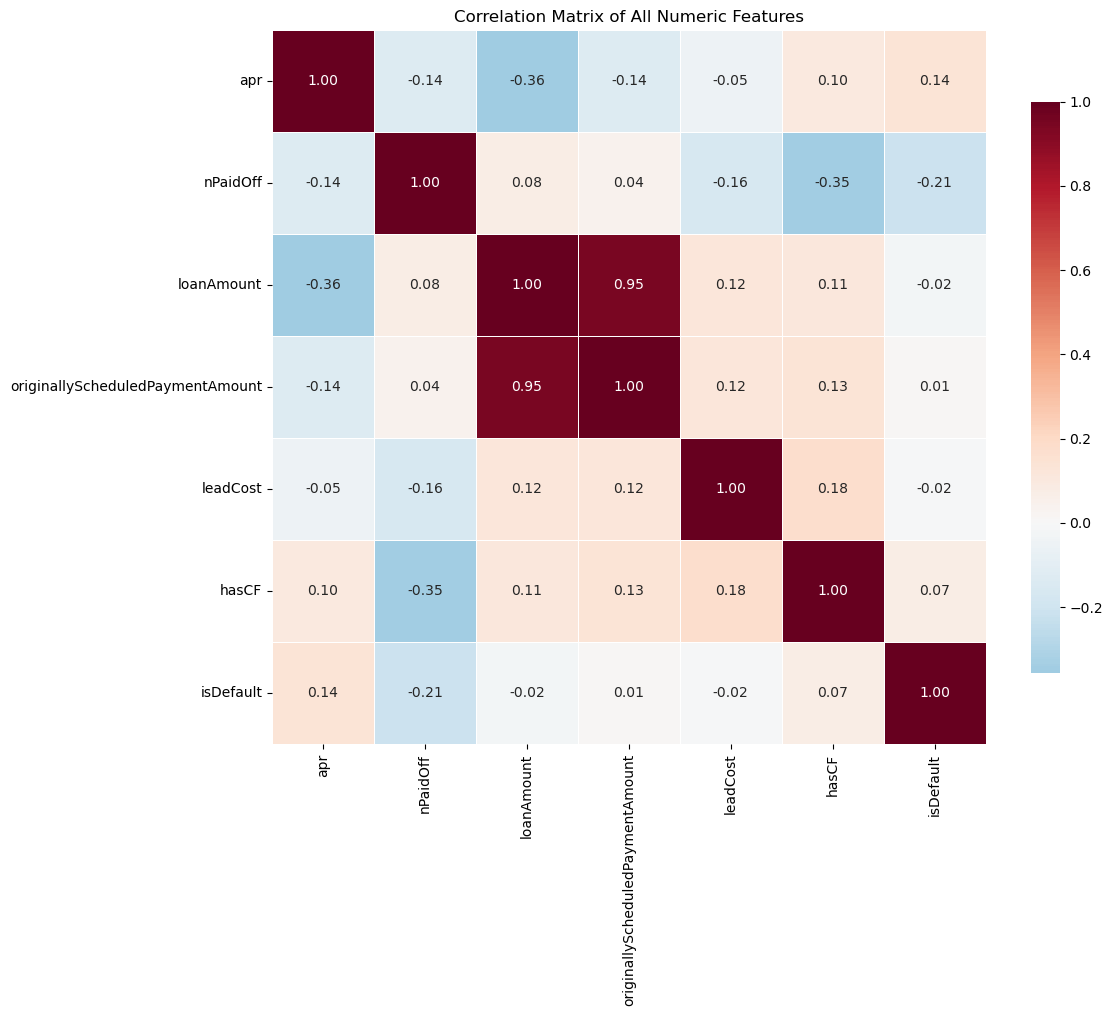

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select only numeric columns
numeric_df = funded_df.select_dtypes(include='number')
numeric_df = numeric_df.drop(columns=['isFunded'])

numeric_df = numeric_df.dropna()

# 3. Compute correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of All Numeric Features")
plt.tight_layout()
plt.show()


**🔍 Key Takeaways from Correlation Matrix**

- **LoanAmount and ScheduledPayment** are **very closely correlated** *(r = 0.95)* — as expected, larger loans lead to larger scheduled payments.

- **APR and LoanAmount** have a **moderate negative correlation** *(r = –0.36)* — smaller loans tend to carry higher APRs.

- **nPaidOff (number of prior paid-off loans)** shows a **negative correlation with default** *(r = –0.21)* — customers with more paid loans are less likely to default.

- **APR and default (isDefault)** have a **mild positive correlation** *(r ≈ +0.14)* — higher APR loans are slightly more prone to default.

- **LeadCost** (marketing cost of acquiring a lead) has **almost no correlation with default** *(r = –0.01)*, though it shows some negative correlation with **nPaidOff** *(r = –0.16)* — likely indicating that returning customers cost less to acquire.

- **Overall:** None of the linear correlations are extremely strong in absolute value. This suggests that **categorical groupings** or **non-linear patterns** likely provide more predictive power. Still, the matrix reinforces the importance of **customer history** (`nPaidOff`) and shows that features like loan amount or APR alone may not linearly explain default risk.


---

## 4. Summary of Insights

In this exploratory analysis, we uncovered several important findings that will guide the loan risk prediction model:

### 🎯 Target Variable
We will use **loan default** as the target outcome, derived from `loanStatus`. Specifically, we label loans as defaulted if they ended up in **collection, charge-off, or similar negative statuses**.  
- It's essential to focus on **funded loans**, as the majority of records were **unfunded applications** (withdrawn or rejected), which are not relevant for repayment risk but useful for understanding pipeline conversion.

### ⚖️ Class Imbalance
Among funded loans, the **default rate is high (~60%)**, meaning the "bad" outcome is actually more common than the "good" one.  
- However, there remains a sizable **~40% of loans that were paid off**.  
- The model must handle this imbalance while still accurately predicting the minority class (paid loans).

### 👤 Customer Tenure & Behavior
One of the strongest predictors is **borrower tenure**:
- **New borrowers** (no prior paid loans) default at nearly **twice the rate** of those with at least one successful loan.
- Including features like `nPaidOff` or an “existing customer” flag will significantly enhance model performance.

### 🌐 Lead Source
How the borrower was acquired strongly correlates with default:
- **High-cost, purchased leads** (`bvMandatory`, `lead`) show **default rates of 60–69%**.
- **Organic and returning customers** show much lower default (~30–45%).  
- This likely reflects differences in **borrower quality**, and `leadType` should be included in the model.

### 💲 Loan Terms (APR & Amount)
- **Higher APR** loans show slightly higher default rates, consistent with **risk-based pricing**.  
- **Loan amount**, however, does **not show a strong correlation** with default, likely due to lender-imposed limits on high-risk borrowers.  
- These can still be included, but are less predictive than customer history or lead source.

### ⏳ Repayment Schedule
- Borrowers on **weekly or biweekly schedules** had **higher default rates** than those on monthly terms.
- The **“Irregular” schedule** group had the **lowest default**, potentially indicating a special borrower group.
- `payFrequency` is a valuable categorical feature to include.

### 🗺️ Geography
- **Default rates vary by state**, suggesting regional or regulatory effects.
- States like **Texas and Florida** showed notably higher risk.
- Including **`state` or region** as a model feature could capture this variability.

### 🧹 Data Quality Considerations
- Many fields are **missing or irrelevant for non-funded loans**. The model will be trained only on funded loans.
- Post-funding features like `fpStatus` could **leak information** and bias the model — these will be excluded from the initial model.
- **Active loans** should be handled carefully — they are neither defaults nor payoffs. For clarity, we may **exclude them** from training to focus only on completed outcomes.

### 📉 Pipeline Insight
Although not the modeling focus, we note that only **~7% of all applications were funded**.  
- Most were withdrawn or rejected early, possibly filtered by rule-based checks.
- This highlights the importance of modeling post-underwriting, since **even approved loans default at a 60% rate**.  
- This reinforces the need for a predictive model to **further refine loan decisions** beyond manual or rules-based filters.
